In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Task 1 : Clean/dirty classification and analysis

## Preprocessing and Visualisation

In [63]:
df = pd.read_csv("clean-dirty-metadata.csv",sep=';')
df = df.drop(['source','x_lat','y_lon','annotation_path'],axis=1)
df["label"] = (df["label"] == "clean").astype(int)
df

,image_path,split,label
0,clean-dirty-garbage-containers/train/clean/001...,train,1
1,clean-dirty-garbage-containers/train/clean/001...,train,1
2,clean-dirty-garbage-containers/train/clean/001...,train,1
3,clean-dirty-garbage-containers/train/clean/001...,train,1
4,clean-dirty-garbage-containers/train/clean/001...,train,1
...,...,...,...
3407,clean-dirty-garbage-containers/test/dirty/e8e1...,test,0
3408,clean-dirty-garbage-containers/test/dirty/f02b...,test,0
3409,clean-dirty-garbage-containers/test/dirty/f29b...,test,0
3410,clean-dirty-garbage-containers/test/dirty/fc02...,test,0


In [75]:
IMG_WIDTH=32
IMG_HEIGHT=32

#get pathname and convert the image into the right shape
df["images"]=""
for i in range(len(df)) :
    im = cv2.imread(df["image_path"][i].partition("/")[2], cv2.COLOR_BGR2GRAY)
    image = cv2.resize(im, (IMG_HEIGHT, IMG_WIDTH))
    image = np.array(image)
    image = image.astype('float32')
    image /= 255 
    df["images"][i]=image.astype(float)
    

In [76]:
'''# to have a smaller dataset to work with
from sklearn.utils import shuffle
df = shuffle(df)
df1 = df[:200]
df1
'''
# split into train and test
df_train = df[df.split == 'train']
df_test = df[df.split == 'test']

#keep interesting column
train_df = df_train.drop(['image_path','split'],axis=1)
test_df = df_test.drop(['image_path','split'],axis=1)

<AxesSubplot:ylabel='count'>

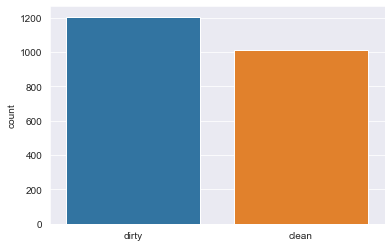

In [77]:
#visualisation to see if my dataset is balance
l = []
for i in df_train.label:
    if(i == 0):
        l.append("clean")
    else:
        l.append("dirty")
sns.set_style('darkgrid')
sns.countplot(l)

In [78]:
#Convert the target arrays to one-hot encodings
'''from keras.utils.np_utils import to_categorical
y_train = tf.keras.utils.to_categorical(
    train_df['label'], num_classes=None, dtype='float32'
)

y_test = tf.keras.utils.to_categorical(
    test_df['label'], num_classes=None, dtype='float32'
)'''
#one or the other I test
y_train = np.asarray(train_df['label']).astype('float32').reshape((-1,1))
y_test = np.asarray(test_df['label']).astype('float32').reshape((-1,1))

In [79]:
#convert to numpy array 
#!!! suppose to be the same for test but there is a bug and I will deal with it later(tired!!)
train = []
for i in range(len(train_df)):
    train.append(train_df['images'][i])
x_train = np.array(train)

test = []
for index, row in test_df.iterrows():
    test.append(row['images'])
x_test = np.array(test)

In [80]:
print("Shape of training data", x_train.shape)
print("\nShape of test data", x_test.shape)

Shape of training data (2217, 32, 32, 3)

Shape of test data (1195, 32, 32, 3)


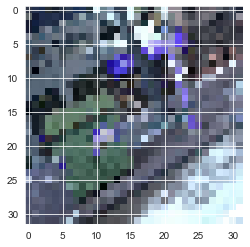

In [81]:
plt.imshow(x_train[630]) #example

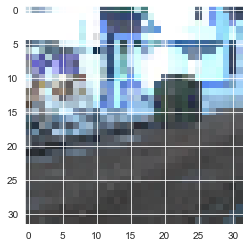

In [82]:
plt.imshow(x_test[61]) #example

## First Naive model

In [83]:
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras import backend as K
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_10 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_11 (Activation)   (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)         

In [84]:
es = EarlyStopping(
    monitor="val_accuracy",
    patience=5
)

history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=50,
    validation_data=(0.1*x_train, 0.1*y_train),callbacks=es
)


Epoch 1/50
35/35 [==============================] - 2s 36ms/step - loss: 0.6836 - accuracy: 0.5611 - val_loss: 0.7110 - val_accuracy: 0.0271
Epoch 2/50
35/35 [==============================] - 1s 34ms/step - loss: 0.6584 - accuracy: 0.6166 - val_loss: 0.7030 - val_accuracy: 0.1795
Epoch 3/50
35/35 [==============================] - 1s 33ms/step - loss: 0.6320 - accuracy: 0.6518 - val_loss: 0.6752 - val_accuracy: 0.3780
Epoch 4/50
35/35 [==============================] - 1s 34ms/step - loss: 0.6227 - accuracy: 0.6676 - val_loss: 0.6411 - val_accuracy: 0.4542
Epoch 5/50
35/35 [==============================] - 1s 33ms/step - loss: 0.6084 - accuracy: 0.6653 - val_loss: 0.6526 - val_accuracy: 0.4263
Epoch 6/50
35/35 [==============================] - 1s 33ms/step - loss: 0.6158 - accuracy: 0.6703 - val_loss: 0.6642 - val_accuracy: 0.4087
Epoch 7/50
35/35 [==============================] - 1s 32ms/step - loss: 0.5986 - accuracy: 0.6897 - val_loss: 0.5915 - val_accuracy: 0.4560
Epoch 8/50
35

## Predictions

In [85]:
y_pred = model.predict(x_test)
print(y_pred)

[[0.6096261 ]
 [0.65471375]
 [0.6258001 ]
 ...
 [0.15633649]
 [0.7037674 ]
 [0.17838588]]


clean street by [92.9] % because the prediction is = [0.071]


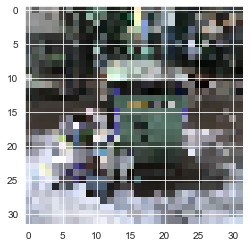

In [86]:
plt.imshow(x_test[1110])
pred = np.round(y_pred[1110],decimals=3)
print('clean street by', np.abs(100 - 100*pred),'%','because the prediction is =',pred)

clean street by [71.7] % [0.283]


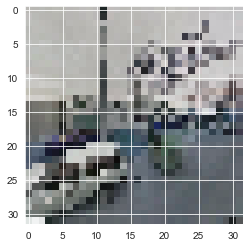

In [87]:
plt.imshow(x_test[10])
pred = np.round(y_pred[10],decimals=3)
print('clean street by', np.abs(100 - 100*pred),'%',pred)

## Evaluation the result

In [88]:
#change y_pred to binary array
for i in range(len(y_pred)):
    if y_pred[i] < 0.5:
        y_pred[i] = 0
    else:
        y_pred[i] = 1

In [89]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[500,  95],
       [243, 357]])

In [90]:
print('Thats mean that we have', cm[0,0], 'true positive', cm[0,1], 'false positive', cm[1,0], 'false positive and', cm[1,1], 'true negative, well done!')

Thats mean that we have 500 true positive 95 false positive 243 false positive and 357 true negative, well done!


In [91]:
#Accuracy
from sklearn.metrics import accuracy_score
print('accuracy score',accuracy_score(y_test, y_pred))
# Recall
from sklearn.metrics import recall_score
print('recall score',recall_score(y_test, y_pred))
# Precision
from sklearn.metrics import precision_score
print('precision score',precision_score(y_test, y_pred))
from sklearn.metrics import f1_score
print('f1 score',f1_score(y_test, y_pred))

accuracy score 0.7171548117154811
recall score 0.595
precision score 0.7898230088495575
f1 score 0.6787072243346007


# Task 2: Network interpretation:

In [49]:
from tensorflow.keras.models import Model

def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str
    Returns 
      uint8 numpy array with shape (img_height, img_width)
    '''
    gradModel = Model(
            inputs=[model.inputs],
            outputs=[model.get_layer(layer_name).output,
            model.output])
    
    with tf.GradientTape() as tape:
    # cast the image tensor to a float-32 data type, pass the image through the gradient model, and grab the loss associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension(which we don't need) so let's grab the volume itself and discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them as weights, compute the ponderation of the filters withrespect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize the output class activation map to match the input imagedimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    # normalize the heatmap such that all values lie in the range [0, 1], scale the resulting values to the range [0, 255],
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8") return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

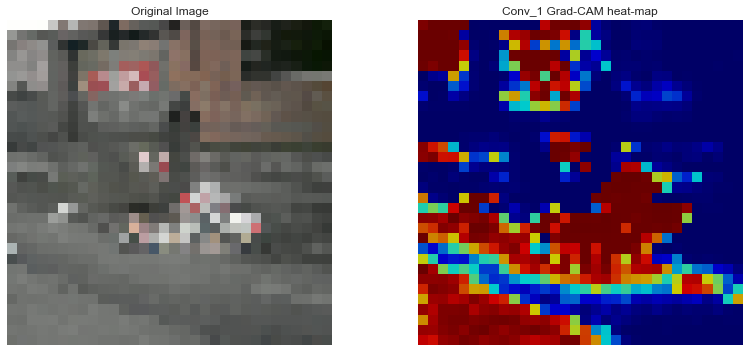

In [50]:
## Grad-CAM heatmap for the last convolutional layer in the model, Conv_1
layer_name = 'conv2d'
grad_cam=GradCam(model,np.expand_dims(image, axis=0),layer_name)
grad_cam_superimposed = superimpose(image, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
plt.tight_layout()

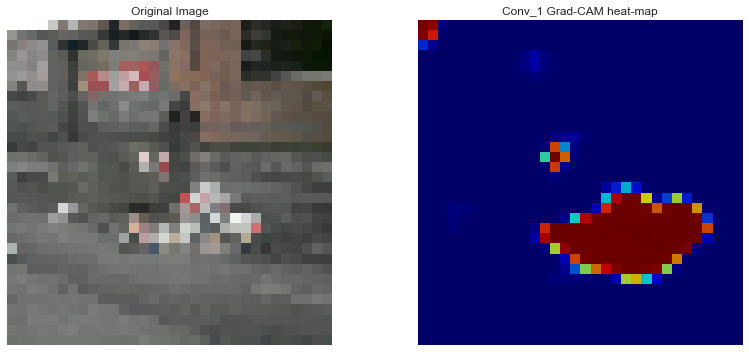

In [51]:
## Grad-CAM heatmap for the last convolutional layer in the model, Conv_1
layer_name = 'activation_1'
grad_cam=GradCam(model,np.expand_dims(image, axis=0),layer_name)
grad_cam_superimposed = superimpose(image, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
plt.tight_layout()

In [52]:
## Gather all convolution and activation layers from the model
## With these layers, we can explore grad-cam heatmaps for more layers in the model

conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and layer.__class__.__name__ == 'ReLU']
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tf.keras.layers.Conv2D))]

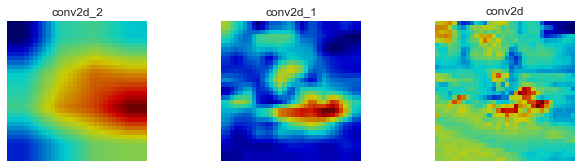

In [53]:
## Visualizing Activation layers
plt.figure(figsize=(15, 15))
for i, layer in enumerate(all_layers):
  grad_cam = GradCam(model, np.expand_dims(image, axis=0), layer)
  grad_cam_emphasized = superimpose(image, grad_cam, 0.5, emphasize=False)
  ax = plt.subplot(7, 5, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()

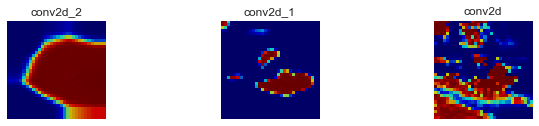

In [54]:
## Visualizing Convolution layers
plt.figure(figsize=(12, 20))
for i, layer in enumerate(conv2D_layers):
  grad_cam = GradCam(model, np.expand_dims(image, axis=0), layer)
  grad_cam_emphasized = superimpose(image, grad_cam, 0.5, emphasize=True)
  ax = plt.subplot(13, 4, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()

In [59]:
def fuse_layers(layers, model, img, emphasize=False):
  '''
    Fuses grad-cam heatmaps from a list of model layers into a single heatmap
    and superimposes the heatmap onto an image.

    Args:
      layers: list of strings
      model: tf model
      img: (img_width x img_height x 3) numpy array


    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
  cams = []
  for layer in layers:
    cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cams.append(cam)

  fused = np.mean(cams, axis=0)
  superimposed = superimpose(img, fused, 0.5, emphasize=emphasize)
  return superimposed


In [60]:
## Using the fuse_layers function, lets fuse together all layers in the model

fused = fuse_layers(all_layers, model, image, True)

Text(0.5, 1.0, 'All layers Grad-CAM heat-map')

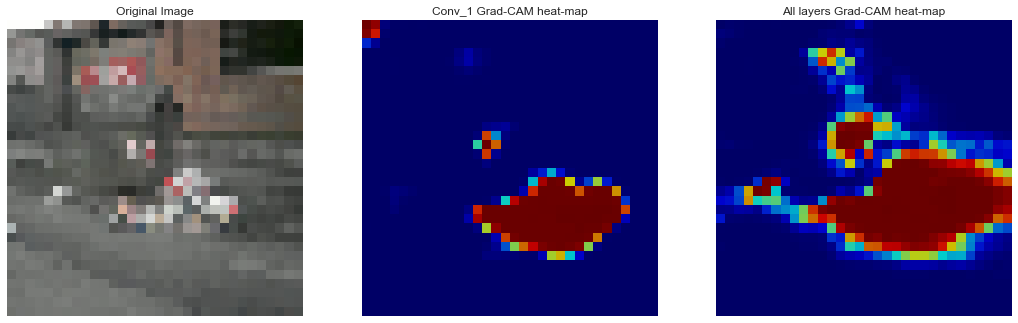

In [61]:
## We can see how fusing together all layers improves upon the Grad-CAM from the last
## convolutional layer in the model
plt.figure(figsize=(18, 8))
ax = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 3, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
ax = plt.subplot(1, 3, 3)
plt.imshow(fused)
plt.axis('off')
plt.title('All layers Grad-CAM heat-map')